In [1]:
import os, sys

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import anndata as annd
import scanpy as sc

import rpy2.rinterface_lib.callbacks
import logging

import matplotlib as mpl

## Get sequences for dataset

This workflow to get sequences was inspired by [notebooks/functions from this repository](https://github.com/emdann/scATAC_prep).

In [2]:
%load_ext rpy2.ipython

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

## Load dataset

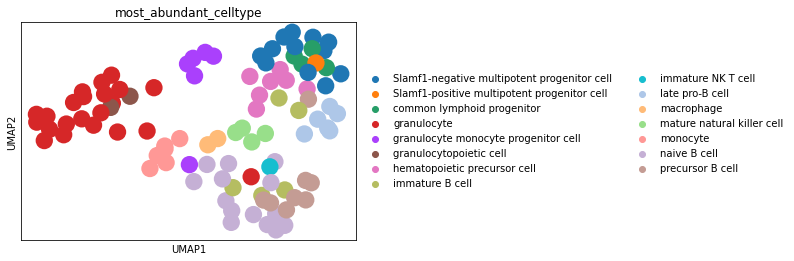

In [5]:
ad = annd.read("data/Marrow_pooled.h5ad")
sc.pl.umap(ad, color='most_abundant_celltype')

In [6]:
gene_ids = ad.var["symbol"]
gene_ids[0:10]

0610005C13Rik    0610005C13Rik
0610007C21Rik    0610007C21Rik
0610007L01Rik    0610007L01Rik
0610007N19Rik    0610007N19Rik
0610007P08Rik    0610007P08Rik
0610007P14Rik    0610007P14Rik
0610007P22Rik    0610007P22Rik
0610008F07Rik    0610008F07Rik
0610009B14Rik    0610009B14Rik
0610009B22Rik    0610009B22Rik
Name: symbol, dtype: object

## Use R to extract sequences

Most/all of these are available through R's package manager or Bioconductor. 

For human genome, use `library(EnsDb.Hsapiens.v86)` instead.

In [7]:
%%R 
library(Matrix)
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Mmusculus.v79) 
library(Biostrings)
library(tidyr)
library(AnnotationHub)
options(stringsAsFactors = F)

In [8]:
%%R 

genome <- ensembldb:::getGenomeTwoBitFile(EnsDb.Mmusculus.v79)
genome_genes <- ensembldb::genes(EnsDb.Mmusculus.v79)

Since we are working with symbols, we set the gene names to symbols:

In [9]:
%%R

names(genome_genes) <- genome_genes$symbol

Get genes and filter out those that are not included:

In [10]:
%%R -i gene_ids -o gene_ids

gene_ids <- as.vector(gene_ids)

good_seqname <- as.character(seqnames(genome_genes)) %in% c(as.character(1:19), "MT", "X", "Y") 
genome_genes <- genome_genes[good_seqname]

gene_ids <- gene_ids[gene_ids %in% genome_genes$symbol]

## Define sequence length relative to (canonical) TSS of genes and extract sequences

In [11]:
%%R -i gene_ids -o promoter_seq

upstream = 500
downstream = 500
# This returns a GRanges object:
promoter_ranges <- GenomicRanges::promoters(genome_genes[gene_ids], 
                                            upstream = upstream, 
                                            downstream = downstream)

promoter_seq <- Biostrings::getSeq(genome, promoter_ranges)
promoter_seq <- tolower(as.character(promoter_seq))

In [12]:
ad = ad[:,ad.var["symbol"].isin(gene_ids)]

In [13]:
ad.var["promoter_seq"] = promoter_seq

/var/folders/j7/vcxpmmm13yjf_k3yh5tcyh3m000l1q/T/ipykernel_70420/4285564113.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad.var["promoter_seq"] = promoter_seq


In [14]:
sum(["N" in x for x in ad.var["promoter_seq"]])

0

In [15]:
ad.var

,symbol,promoter_seq
0610005C13Rik,0610005C13Rik,ttggtcatctgaatctggaggtctgcagcctgagagaaagaaataa...
0610007P14Rik,0610007P14Rik,gggaccacgctctgcttcacctccctcctccttccccagcccgaat...
0610009B22Rik,0610009B22Rik,gaagtcaatgatttttagccaaagtagcttcgaaatgtctgtttaa...
0610009L18Rik,0610009L18Rik,gaggagtgcagtccccaccccgggcggcgtaaccgtcggctaccgg...
0610009O20Rik,0610009O20Rik,attagccagatatctctttggtggttaagttacatcgcaaaaggtt...
...,...,...
Zyx,Zyx,cttgtccccggggcaatactattgcaggcgggtctagggcaaagcg...
Zzef1,Zzef1,ggctcagcaccacaccaagcccgcatatcctcagcatctatacagc...
Zzz3,Zzz3,agatggcaggtgtgatagtcagtataactataattggtattcttta...
a,a,ccgccctcagcctgctgctcctccctcgtgtcctcccgcccgtcag...


In [16]:
ad.write("data/Marrow_pooled.h5ad")